In [55]:
from __future__ import print_function
import keras
from keras import preprocessing, layers, models, optimizers, regularizers
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [56]:
num_classes = 2
img_rows = 64
img_cols = 64

In [57]:
TRAIN_DIR = "/kaggle/input/catsanddogs/CatsandDogs"
x_train = []
y_train = [] # 1 for cat, 0 for dog

In [58]:
# since data is in small amount, the model often overfits. So I've increased the dataset by also adding flipped 
# images of the cats

# I've also separated out the testing data from the dataset. It now trains on 24800 images and checks on 200 unknown images
k = 0
# reading cats images:
for count in range(12400):
    file_name = TRAIN_DIR + "/cats/" + str(count) + ".jpg"
    x_train.append(cv2.imread(file_name, cv2.IMREAD_GRAYSCALE))
    x_train.append(cv2.flip(x_train[k], 1)) #horizontal flip
    k = k + 2
    y_train.append(1)
    y_train.append(1)

In [59]:
# reading dogs images:
for count in range(12400):
    file_name = TRAIN_DIR + "/dogs/" + str(count) + ".jpg"
    #print(file_name)
    x_train.append(cv2.imread(file_name, cv2.IMREAD_GRAYSCALE))
    x_train.append(cv2.flip(x_train[k], 1))
    k = k + 2 
    y_train.append(0)
    y_train.append(0)

In [60]:
x_test = []
y_test = [] # 1 for cat, 0 for dog

# reading cats images:
for count in range(12400, 12500):
    file_name = TRAIN_DIR + "/cats/" + str(count) + ".jpg"
    #print(file_name)
    x_test.append(cv2.imread(file_name, cv2.IMREAD_GRAYSCALE))
    y_test.append(1)

# reading dogs images:
for count in range(12400, 12500):
    file_name = TRAIN_DIR + "/dogs/" + str(count) + ".jpg"
    #print(file_name)
    x_test.append(cv2.imread(file_name, cv2.IMREAD_GRAYSCALE))
    y_test.append(0)


In [61]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


# making array of the training data
y_train = keras.utils.to_categorical(y_train, num_classes)
print(y_train)

# making array of the training data
y_test = keras.utils.to_categorical(y_test, num_classes)

(49600, 64, 64)
(49600,)
(200, 64, 64)
(200,)
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [62]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (49600, 64, 64, 1)
49600 train samples
200 test samples


In [63]:
# SETTING:


batch_size = 50 # it is the number of images utilized in one iteration
learning_rate = 0.00003 # it is the number by which the model converges
drop_out = 0.5 # percentage of layers that are randomly dropped out
epochs = 100

In [64]:
# TRAINING:

model = Sequential()

# first layer:
model.add(Conv2D(kernel_size=(3, 3),
                 filters = 3,
                 activation='relu',
                 input_shape=input_shape,
                 padding="valid"))


# second layer:
model.add(Conv2D(kernel_size=(3, 3),
                 filters = 10,
                 activation='relu',
                 padding="same"))

# Max Pooling:
model.add(MaxPooling2D(pool_size=(2, 2), 
                       strides = (2, 2)))


# third layer:
model.add(Conv2D(kernel_size=(3, 3),
                 filters = 3,
                 activation='relu',
                 padding="same"))

# forth layer:
model.add(Conv2D(kernel_size=(5, 5),
                 filters = 5,
                 activation='relu',
                 padding="same"))

# Max Pooling:
model.add(MaxPooling2D(pool_size=(3, 3), 
                       strides = (2,2)))

# fifth layer:
model.add(Conv2D(kernel_size=(2, 2),
                 strides = (2,2),
                 filters = 10))

model.add(Flatten())

model.add(Dropout(drop_out))

# Fully Connected Layer:

model.add(Dense(100, activation='sigmoid'))
model.add(Dense(2, activation='sigmoid'))


model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 62, 62, 3)         30        
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 62, 62, 10)        280       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 31, 31, 10)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 31, 31, 3)         273       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 31, 31, 5)         380       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 15, 15, 5)         0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 7, 7, 10)          210       
__________

In [65]:
# making checkpoint to save best weights

checkpoint = ModelCheckpoint(filepath = 'weight.hdf5',
                            monitor = 'val_acc',
                            verbose = 0,
                            save_best_only = True)

In [66]:
# adam is used as an optimizer since it works better and converges more faster than the SGD optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

fit = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                callbacks = [checkpoint],
                validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)

# on 40 epochs, the data returned 83% accuracy.

Train on 49600 samples, validate on 200 samples
Epoch 1/100
49600/49600 [==============================] - 10s 195us/step - loss: 0.6503 - acc: 0.6077 - val_loss: 0.6339 - val_acc: 0.6175
Epoch 2/100
49600/49600 [==============================] - 8s 164us/step - loss: 0.6003 - acc: 0.6736 - val_loss: 0.6226 - val_acc: 0.6700
Epoch 3/100
49600/49600 [==============================] - 8s 163us/step - loss: 0.5830 - acc: 0.6897 - val_loss: 0.6012 - val_acc: 0.6850
Epoch 4/100
49600/49600 [==============================] - 8s 164us/step - loss: 0.5731 - acc: 0.6956 - val_loss: 0.5561 - val_acc: 0.7350
Epoch 5/100
49600/49600 [==============================] - 8s 164us/step - loss: 0.5640 - acc: 0.7054 - val_loss: 0.5553 - val_acc: 0.7150
Epoch 6/100
49600/49600 [==============================] - 8s 163us/step - loss: 0.5551 - acc: 0.7128 - val_loss: 0.5287 - val_acc: 0.7725
Epoch 7/100
49600/49600 [==============================] - 8s 164us/step - loss: 0.5479 - acc: 0.7181 - val_loss: 0.5

49600/49600 [==============================] - 8s 162us/step - loss: 0.4134 - acc: 0.8046 - val_loss: 0.4666 - val_acc: 0.7600
Epoch 60/100
49600/49600 [==============================] - 8s 162us/step - loss: 0.4096 - acc: 0.8074 - val_loss: 0.4730 - val_acc: 0.7575
Epoch 61/100
49600/49600 [==============================] - 8s 163us/step - loss: 0.4087 - acc: 0.8091 - val_loss: 0.4658 - val_acc: 0.7500
Epoch 62/100
49600/49600 [==============================] - 8s 163us/step - loss: 0.4098 - acc: 0.8090 - val_loss: 0.4690 - val_acc: 0.7450
Epoch 63/100
49600/49600 [==============================] - 8s 162us/step - loss: 0.4079 - acc: 0.8080 - val_loss: 0.4831 - val_acc: 0.7425
Epoch 64/100
49600/49600 [==============================] - 8s 162us/step - loss: 0.4045 - acc: 0.8111 - val_loss: 0.4880 - val_acc: 0.7300
Epoch 65/100
49600/49600 [==============================] - 8s 162us/step - loss: 0.4032 - acc: 0.8111 - val_loss: 0.4753 - val_acc: 0.7325
Epoch 66/100
49600/49600 [=======

In [67]:
model.load_weights('weight.hdf5')
scr = model.evaluate(x_test, y_test, verbose = 0)
print("Accuracy is %.2f%%" %(scr[1] * 100))

Accuracy is 78.00%


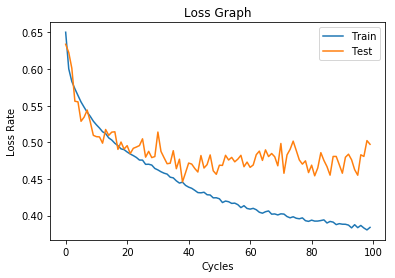

In [68]:
# Loss Graph: Shows how the loss changed over the 4 cycles
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.title('Loss Graph')
plt.xlabel('Cycles')
plt.ylabel('Loss Rate')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

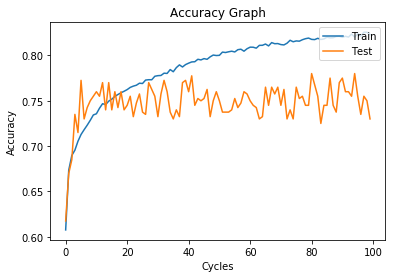

In [69]:
# Accuracy Graph: Shows how the accuracy changed over the 4 cycles
plt.plot(fit.history['acc'])
plt.plot(fit.history['val_acc'])
plt.title('Accuracy Graph')
plt.xlabel('Cycles')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()